In [3]:
import numpy as np

#
#  statstar.py
#
#  This program is a Python version of the code STATSTAR written
#  in FORTRAN and described in Carroll and Ostlie.  Program
#  has been modified and converted to Python in Fall 2010 
#  by Prof. D. Schiminovich at Columbia University 
#  for use in C3101 Stellar Structure and Evolution
#
#  Notes from FORTRAN code:
#
#  This program is listed in Appendix H of both "An Introduction
#  to Modern Astrophysics," Bradley W. Carroll and Dale A. Ostlie,
#  Addison-Wesley Publishing Company, copyright 1996, and "An 
#  Introduction to Modern Stellar Astrophysics," Dale A. Ostlie
#  and Bradley W. Carroll, Addison-Wesley Publishing Company,
#  copyright 1996.
#
#  This program will calculate a static stellar model using the 
#  equations developed in the text.  The user is expected to supply the
#  star's mass, luminosity, effective temperature, and composition 
#  (X and Z).  If the choices for these quantities are not consistent 
#  with the central boundary conditions, an error message will be 
#  generated and the user will then need to supply a different set of
#  initial values.

#  SUBROUTINES

#  Subroutine STARTMDL computes values of M_r, L_r, P, and T, near the
#  surface of the star using expansions of the stellar structure
#  equations (M_r and L_r are assumed to be constant).
#
def STARTMDL(deltar, X, Z, mu, Rs, r_i, M_ri, L_ri, tog_bf,irc,cst):
#
#     X = hydrogen mass fraction
#     Z = metal mass fraction
#     mu = mean molecular weight
#     Rs = radius of star
#     r_i = radius of shell
#     M_ri = mass enclosed within shell at this radius 
#          (assumed constant at start of model)
#     L_ri = enclosed luminosity, assumed constant
#
      r = r_i + deltar
      M_rip1 = M_ri
      L_rip1 = L_ri
#
#  This is the radiative approximation (neglect radiation pressure
#  and electron scattering opacity)# see Prialnik Eq. 5.1, 5.3 and Sec. 3.7 or C&O Eqs. (H.1), (H.2), (9.19),
#  and (9.20).
#
      if (irc == 0):
          T_ip1 = cst.G*M_rip1*mu*cst.m_H/(4.25e0*cst.k_B)*(1.0e0/r - 1.0e0/Rs)
          A_bf = 4.34e25*Z*(1.0e0 + X)/tog_bf
          A_ff = 3.68e22*cst.g_ff*(1.0e0 - Z)*(1.0e0 + X)
          Afac = A_bf + A_ff
          P_ip1 = np.sqrt((1.0e0/4.25e0)*(16.0e0/3.0e0*np.pi*cst.a*cst.c)*(cst.G*M_rip1/L_rip1)*(cst.k_B/(Afac*mu*cst.m_H)))*T_ip1**4.25e0

#
#  This is the convective approximation# see Prialnik Sec 6.5, 6.6 or C&O Eqs. (H.3) and (10.75).
#
      else:
          T_ip1 = cst.G*M_rip1*mu*cst.m_H/cst.k_B*(1.0e0/r - 1.0e0/Rs)/cst.gamrat
          P_ip1 = cst.kPad*T_ip1**cst.gamrat

      return r,P_ip1, M_rip1, L_rip1, T_ip1

#
#  Subroutine EOS calculates the values of density, opacity, the 
#  guillotine-to-gaunt factor ratio, and the energy generation rate at
#  the radius r.
#
def   EOS(X, Z, XCNO, mu, P, T,izone,cst):

#
#  Solve for density from the ideal gas law (remove radiation pressure)#
#  see Prialnik Eq. 5.5 or C&O Eq. (10.26).
#
      if ((T < 0.0e0) or (P < 0.0e0)):
          print(' Something is a little wrong here.')
          print(' You are asking me to deal with either a negative temperature')
          print(' or a negative pressure.  I am sorry but that is not in my')
          print(' contract! You will have to try again with different')
          print(' initial conditions.')
          print(' In case it helps, I detected the problem in zone ',izone)
          print(' with the following conditions:')
          print('T = ',T,' K')
          print('P = ',P,' dynes/cm**2')
          return (0.0, 0.0, 0.0,0.0,1)


      Prad = cst.a*T**4/3.0e0
      Pgas = P - Prad
      rho=(mu*cst.m_H/cst.k_B)*(Pgas/T)
      if (rho < 0.0e0):
          print(' I am sorry, but a negative density was detected.')
          print(' my equation-of-state routine is a bit baffled by this new')
          print(' physical system you have created.  The radiation pressure')
          print(' is probably too great, implying that the star is unstable.')
          print(' Please try something a little less radical next time.')
          print(' In case it helps, I detected the problem in zone ')
          print(' with the following conditions:')
          print('T       = {0:12.5E} K'.format(T))
          print('P_total = {0:12.5E} dynes/cm**2'.format(P))
          print('P_rad   = {0:12.5E} dynes/cm**2'.format(Prad))
          print('P_gas   = {0:12.5E} dynes/cm**2'.format(Pgas))
          print('rho     = {0:12.5E} g/cm**3'.format(rho))
          return (rho, 0.0 , 0.0 ,0.0,1)

#
#  Calculate opacity, including the guillotine-to-gaunt factor ratio#
#  see Novotny (1973), p. 469. k_bf, k_ff, and k_e are the bound-free,
#  free-free, and electron scattering opacities, given by Prialnik Sec 3.7 or C&O Eqs. (9.19),
#  (9.20), and (9.21), respectively.
#

      tog_bf = 2.82e0*(rho*(1.0e0 + X))**0.2e0
      k_bf = 4.34e25/tog_bf*Z*(1.0e0 + X)*rho/T**3.5e0
      k_ff = 3.68e22*cst.g_ff*(1.0e0 - Z)*(1.0e0 + X)*rho/T**3.5e0
      k_e = 0.2e0*(1.0e0 + X)
      kappa = k_bf + k_ff + k_e
#
#  Compute energy generation by the pp chain and the CNO cycle.  These
#  are calculated using Eqs. (10.49) and (10.53) Prialnik Eq. 4.6, 4.7 + screening factor, which come from
#  Fowler, Caughlan, and Zimmerman (1975). The screening factor for the
#  pp chain is calculated as fpp# see Clayton (1968), p. 359ff.
#
#     Calculate 1/3 and 2/3 for convenience
      oneo3=0.333333333e0
      twoo3=0.666666667e0

      T6 = T*1.0e-06
      fx = 0.133e0*X*np.sqrt((3.0e0 + X)*rho)/T6**1.5e0
      fpp = 1.0e0 + fx*X
      psipp = 1.0e0 + 1.412e8*(1.0e0/X - 1.0e0)*np.exp(-49.98*T6**((-1.0)*oneo3))
      Cpp = 1.0e0 + 0.0123e0*T6**oneo3 + 0.0109e0*T6**twoo3 + 0.000938e0*T6
      epspp = 2.38e6*rho*X*X*fpp*psipp*Cpp*T6**(-twoo3)*np.exp(-33.80e0*T6**(-oneo3))
      CCNO = 1.0e0 + 0.0027e0*T6**oneo3 - 0.00778e0*T6**twoo3- 0.000149e0*T6
      epsCNO = 8.67e27*rho*X*XCNO*CCNO*T6**(-twoo3)*np.exp(-152.28e0*T6**(-oneo3))
      epslon = epspp + epsCNO

      return (rho, kappa, epslon,tog_bf,0)



#
#  The following four function subprograms calculate the gradients of
#  pressure, mass, luminosity, and temperature at r.

def dPdr(r, M_r, rho,cst):
      return -cst.G*rho*M_r/r**2

def dMdr(r, rho, cst):
      return (4.0e0*np.pi*rho*r**2)

def dLdr(r, rho, epslon,cst):
      return (4.0e0*np.pi*rho*epslon*r**2)

def dTdr(r, M_r, L_r, T, rho, kappa, mu, irc,cst):
      if (irc == 0):
          return (-(3.0e0/(16.0e0*np.pi*cst.a*cst.c))*kappa*rho/T**3*L_r/r**2)
#  This is the adiabatic convective temperature gradient (Prialnik Eq. 6.29 or C&O Eq. 10.81).
      else:
          return (-1.0e0/cst.gamrat*cst.G*M_r/r**2*mu*cst.m_H/cst.k_B)

#
# Runge-kutta algorithm
#
def RUNGE(f_im1, dfdr, r_im1, deltar, irc, X, Z, XCNO,mu, izone,cst):

      f_temp=np.zeros(4)
      f_i=np.zeros(4)

      dr12 = deltar/2.0e0
      dr16 = deltar/6.0e0
      r12  = r_im1 + dr12
      r_i  = r_im1 + deltar
#
#  Calculate intermediate derivatives from the four fundamental stellar
#  structure equations found in Subroutine FUNDEQ.
#
      for i in range(0,4):
          f_temp[i] = f_im1[i] + dr12*dfdr[i]

      df1, ierr = FUNDEQ(r12, f_temp, irc, X, Z, XCNO, mu, izone,cst)
      if (ierr != 0):
          return f_i,ierr
#

      for i in range(0,4):
          f_temp[i] = f_im1[i] + dr12*df1[i]

      df2,ierr = FUNDEQ(r12, f_temp, irc, X, Z, XCNO, mu, izone,cst)
      if (ierr != 0):
          return f_i,ierr

#
      for i in range(0,4):
          f_temp[i] = f_im1[i] + deltar*df2[i]

      df3,ierr=FUNDEQ(r_i, f_temp, irc, X, Z, XCNO, mu, izone,cst)
      if (ierr != 0):
          return f_i,ierr
#
#  Calculate the variables at the next shell (i + 1).
#
      for i in range(0,4):
          f_i[i] = f_im1[i] + dr16*(dfdr[i] + 2.0e0*df1[i] + 2.0e0*df2[i] + df3[i])

      return f_i,0


#
#  This subroutine returns the required derivatives for RUNGE, the
#  Runge-Kutta integration routine.
#
#      Subroutine FUNDEQ(r, f, irc, X, Z, XCNO, mu, izone,cst)

def FUNDEQ(r,f,irc,X,Z,XCNO,mu,izone,cst):

      dfdr=np.zeros(4)
      P   = f[0]
      M_r = f[1]
      L_r = f[2]
      T   = f[3]
      rho,kappa,epslon,tog_bf,ierr = EOS(X, Z, XCNO, mu, P, T, izone,cst)
      dfdr[0] = dPdr(r, M_r, rho,cst)
      dfdr[1] = dMdr(r, rho,cst)
      dfdr[2] = dLdr(r, rho, epslon,cst)
      dfdr[3] = dTdr(r, M_r, L_r, T, rho, kappa, mu, irc,cst)
      return (dfdr,ierr)



def StatStar(Msolar,Lsolar,Te,X,Z):

#
#  Main program for calculating stellar structure
#
#  Variables, run-time parameters and settings:
#
#  deltar = radius integration step
#  idrflg = set size flag
#         = 0 (initial surface step size of Rs/1000.)
#         = 1 (standard step size of Rs/100.)
#         = 2 (core step size of Rs/5000.)
#
#  Nstart = number of steps for which starting equations are to be used
#           (the outermost zone is assumed to be radiative)
#  Nstop = maximum number of allowed zones in the star
#  Igoof = final model condition flag
#        = -1 (number of zones exceeded; also the initial value)
#        =  0 (good model)
#        =  1 (core density was extreme)
#        =  2 (core luminosity was extreme)
#        =  3 (extrapolated core temperature is too low)
#        =  4 (mass became negative before center was reached)
#        =  5 (luminosity became negative before center was reached)
#  X, Y, Z = mass fractions of hydrogen, helium, and metals
#  T0, P0 = surface temperature and pressure (T0 = P0 = 0 is assumed)
#  Ms, Ls, Rs = mass, luminosity, and radius of the star (cgs units)
#

      nsh=999   # maximum number of shells

      # initialize r, P, M_r, L_r, T, rho, kappa, epslon, dlPdlT to
      # an array with nsh elements

      r=np.zeros(nsh,float)
      P=np.zeros(nsh,float)
      M_r=np.zeros(nsh,float)
      L_r=np.zeros(nsh,float)
      T=np.zeros(nsh,float)
      rho=np.zeros(nsh,float)
      kappa=np.zeros(nsh,float)
      epslon=np.zeros(nsh,float)
      tog_bf=np.zeros(nsh,float)
      dlPdlT=np.zeros(nsh,float)

      # initialize other variables

      deltar=0.0
      XCNO=0.0
      mu=0.0
      Ms=0.0
      Ls=0.0
      Rs=0.0
      T0=0.0
      P0=0.0
      Pcore=0.0
      Tcore=0.0
      rhocor=0.0
      epscor=0.0
      rhomax=0.0
      Rsolar=0.0

      Y=1.0-(X+Z)


      #     tog_bf = bound-free opacity constant
      #             (ratio of guillotine to gaunt factors)
      tog_bf0=0.01


      # initialize variables used for 4 structure equation derivatives

      f_im1=np.zeros(4,float)
      dfdr=np.zeros(4,float)
      f_i=np.zeros(4,float)


      # Various run time parameters

      Nstart=10
      Nstop=999
      Igoof=-1
      ierr=0
      P0=0.0
      T0=0.0
      dlPlim=99.9
      debug=0

      #
      #  Assign values to constants (cgs units)
      #     Rsun = radius of the Sun
      #     Msun = mass of the Sun
      #     Lsun = luminosity of the Sun
      #     sigma = Stefan-Boltzmann constant
      #     c = speed of light in vacuum
      #     a = 4*sigma/c (radiation pressure constant)
      #     G = universal gravitational constant
      #     K_B = Boltzmann constant
      #     m_H = mass of hydrogen atom
      #     gamma = 5/3 (adiabatic gamma for a monatomic gas)
      #     gamrat = gamma/(gamma-1)
      #     kPad = P/T**(gamma/(gamma-1)) (adiabatic gas law constant)
      #     g_ff = free-free opacity gaunt factor (assumed to be unity)
      #

      Rsun=6.9599e10
      Msun=1.989e33
      Lsun=3.826e33

      # For convenience we will store most constants in a single variable

      class Constants:
           pass
      cst = Constants()

      cst.sigma=5.67051e-5
      cst.c=2.99792458e10
      cst.a=7.56591e-15
      cst.G=6.67259e-8
      cst.k_B=1.380658e-16
      cst.m_H=1.673534e-24
      cst.gamma= 5.0e0/3
      cst.g_ff= 1.0e0

#
#  Select the mass fraction CNO to be 50% of Z.
#
      XCNO = Z/2.0e0
#
#  Calculate the mass, luminosity, and radius of the star.
#  The radius is calculated from Prialnik Eq. 1.3 (C&O Eq. 3.17).
#
      Ms = Msolar*Msun
      Ls = Lsolar*Lsun
      Rs = np.sqrt(Ls/(4.e0*np.pi*cst.sigma))/Te**2
      Rsolar = Rs/Rsun
#
#  Begin with a very small step size since surface conditions vary
#  rapidly.
#
      deltar = -Rs/1000.0e0
      idrflg = 0
#
#  Calculate mean molecular weight mu assuming complete ionization
#  (see Prialnik Eq. 3.18, 3.25 or C&O Eq. 10.21).
#
      mu = 1.0e0/(2.0*X + 0.75*Y + 0.5*Z)
#
#  Calculate the delimiter between adiabatic convection and radiation
#  (see Prialnik Eq. 6.28 or C&O Eq. 10.87).
#
      cst.gamrat = cst.gamma/(cst.gamma - 1.0e0)
#
#  Initialize values of r, P, M_r, L_r, T, rho, kappa, and epslon at
#  the surface.  The outermost zone is assumed to be zone 1.  The zone
#  number increases toward the center.
#

      initsh=0
      r[initsh]   = Rs
      M_r[initsh] = Ms
      L_r[initsh] = Ls
      T[initsh]   = T0
      P[initsh]   = P0
      tog_bf[initsh]   = tog_bf0


      if (P0 <= 0.0) or (T0 <= 0.0):
          rho[initsh]    = 0.0
          kappa[initsh]  = 0.0
          epslon[initsh] = 0.0
          tog_bf[initsh] = 0.01
      else:
          rho[initsh],kappa[initsh],epslon[initsh],tog_bf[initsh],ierr=EOS(X, Z, XCNO, mu, P[initsh], T[initsh], 0 ,cst)
          if ierr != 0:
              print ("we're stopping now")
              istop=0

#
#  Apply approximate surface solutions to begin the integration,
#  assuming radiation transport in the outermost zone (the do 20 loop).
#  irc = 0 for radiation, irc = 1 for convection.
#  Assume arbitrary initial values for kPad, and dlPdlT.
#  dlPdlT = dlnP/dlnT (see Prialnik Eq. 6.28 or C&O Eq. 10.87)
#
      cst.kPad = 0.3e0
      irc = 0
      dlPdlT[initsh] = 4.25e0
      for i in range(0,Nstart):
          ip1 = i + 1
          r[ip1],P[ip1],M_r[ip1],L_r[ip1],T[ip1]=STARTMDL(deltar, X, Z, mu, Rs, r[i], M_r[i], L_r[i], tog_bf[i], irc,cst)
          rho[ip1],kappa[ip1],epslon[ip1],tog_bf[ip1],ierr=EOS(X, Z, XCNO, mu, P[ip1], T[ip1], ip1 ,cst)

          if ierr != 0:
              print('Values from the previous zone are:')
              print('r/Rs      = {0:12.5E}'.format(r[i]/Rs))
              print('rho       = {0:12.5E}  g/cm**3'.format(rho[i]))
              print('M_r/Ms    = {0:12.5E}'.format(M_r[i]/Ms))
              print('kappa     = {0:12.5E}  cm**2/g'.format(kappa[i]))
              print('T         = {0:12.5E}  K'.format(T[i]))
              print('epsilon   = {0:12.5E}  ergs/g/s'.format(epslon[i]))
              print('P         = {0:12.5E}  dynes/cm**2'.format(P[i]))
              print('L_r/Ls    = {0:12.5E}'.format(L_r[i]/Ls))
              break
#
#  Determine whether convection will be operating in the next zone by
#  calculating dlnP/dlnT numerically between zones i and i+1 [ip1].
#  Update the adiabatic gas constant if necessary.
#
          if (i > initsh):
              dlPdlT[ip1] = np.log(P[ip1]/P[i])/np.log(T[ip1]/T[i])
          else:
              dlPdlT[ip1] = dlPdlT[i]

          if (dlPdlT[ip1] < cst.gamrat):
              irc = 1
          else:
              irc = 0
              cst.kPad = P[ip1]/T[ip1]**cst.gamrat

#
#  Test to see whether the surface assumption of constant mass is still
#  valid.
#
          deltaM = deltar*dMdr(r[ip1], rho[ip1],cst)
          M_r[ip1] = M_r[i] + deltaM
          if (np.abs(deltaM) > (0.001e0*Ms)):
              if (ip1 > 1):
                  ip1 = ip1 - 1
                  print(' The variation in mass has become larger than 0.001*Ms')
                  print(' leaving the approximation loop before Nstart was reached')
                  break
#
#
#  =============  MAIN LOOP ==========================
#
#  This is the main integration loop.  The assumptions of constant
#  interior mass and luminosity are no longer applied.
#
#  Initialize the Runge-Kutta routine by specifying zone i-1 quantities
#  and their derivatives.  Note that the pressure, mass, luminosity,
#  and temperature are stored in the memory locations f_im1(1),
#  f_im1(2), f_im1(3), and f_im1(4), respectively.  The derivatives of
#  those quantities with respect to radius are stored in dfdr(1),
#  dfdr(2), dfdr(3), and dfdr(4).  Finally, the resulting values for
#  P, M_r, L_r, and T are returned from the Runge-Kutta routine in
#  f_i(1), f_i(2), f_i(3), and f_i(4), respectively.
#
#  The stellar structure equations
#           dPdr (Prialnik 5.1 or C&O Eq. 10.7)
#           dMdr (Prialnik 5.2 or C&O Eq. 10.8)
#           dLdr (Prialnik 5.4 or C&O Eq. 10.45) and
#           dTdr (Prialnik 5.3 or C&O Eq. 10.61 or Eq. 10.81)
#           are calculated in function calls, defined previously in the code.
#

      Nsrtp1 = ip1 + 1

      if (ierr != 0):    # exit if we've arrived at this point after an error in initialization
          Nstop=Nsrtp1-1
          istop=Nstop

      for i in range(Nsrtp1,Nstop):
          im1 = i - 1
          f_im1[0] = P[im1]
          f_im1[1] = M_r[im1]
          f_im1[2] = L_r[im1]
          f_im1[3] = T[im1]
          dfdr[0]  = dPdr(r[im1], M_r[im1], rho[im1],cst)
          dfdr[1]  = dMdr(r[im1], rho[im1],cst)
          dfdr[2]  = dLdr(r[im1], rho[im1], epslon[im1],cst)
          dfdr[3]  = dTdr(r[im1], M_r[im1], L_r[im1], T[im1], rho[im1],kappa[im1], mu, irc,cst)
          f_i,ierr=RUNGE(f_im1, dfdr, r[im1], deltar, irc, X, Z, XCNO, mu, i,cst)

          if (ierr != 0):
              print(' The problem occurred in the Runge-Kutta routine')
              print(' Values from the previous zone are:')
              print('r/Rs    = {0:12.5e}'.format(r[im1]/Rs))
              print('rho     = {0:12.5e} g/cm**3'.format(rho[im1]))
              print('M_r/Ms  = {0:12.5e}'.format(M_r[im1]/Ms))
              print('kappa   = {0:12.5e} cm**2/g'.format(kappa[im1]))
              print('T       = {0:12.5e} K'.format(T[im1]))
              print('epsilon = {0:12.5e} ergs/g/s'.format(epslon[im1]))
              print('P       = {0:12.5e} dynes/cm**2'.format(P[im1]))
              print('L_r/Ls  = {0:12.5e}'.format(L_r[im1]/Ls))
              break
#
#  Update stellar parameters for the next zone, including adding
#  dr to the old radius (note that dr <  0 since the integration is
#  inward).
#
          r[i]   = r[im1] + deltar
          P[i]   = f_i[0]
          M_r[i] = f_i[1]
          L_r[i] = f_i[2]
          T[i]   = f_i[3]
#
#  Calculate the density, opacity, and energy generation rate for
#  this zone.
#
          rho[i],kappa[i],epslon[i],tog_bf[i],ierr=EOS(X, Z, XCNO, mu, P[i], T[i], i, cst)

          if (ierr != 0):
              print(' Values from the previous zone are:')
              print('r/Rs    = {0:12.5e}'.format(r[im1]/Rs))
              print('rho     = {0:12.5e} g/cm**3'.format(rho[im1]))
              print('M_r/Ms  = {0:12.5e}'.format(M_r[im1]/Ms))
              print('kappa   = {0:12.5e} cm**2/g'.format(kappa[im1]))
              print('T       = {0:12.5e} K'.format(T[im1]))
              print('epsilon = {0:12.5e} ergs/g/s'.format(epslon[im1]))
              print('P       = {0:12.5e} dynes/cm**2'.format(P[im1]))
              print('L_r/Ls  = {0:12.5e}'.format(L_r[im1]/Ls))
              istop = i
              break

          if (debug == 1): print (i,r[i],M_r[i],L_r[i],T[i],P[i],rho[i],kappa[i],epslon[i],tog_bf[i])



#
#  Determine whether convection will be operating in the next zone by
#  calculating dlnP/dlnT and comparing it to gamma/(gamma-1)
#  (see Prialnik Eq. 6.28 or C&O Eq. 10.87).  Set the convection flag appropriately.
#
          dlPdlT[i] = np.log(P[i]/P[im1])/np.log(T[i]/T[im1])
          if (dlPdlT[i] < cst.gamrat):
              irc = 1
          else:
              irc = 0

#
#  Check to see whether the center has been reached.  If so, set Igoof and
#  estimate the central conditions rhocor, epscor, Pcore, and Tcore.
#  The central density is estimated to be the average density of the
#  remaining central ball, the central pressure is determined by
#  using Taylor expansion at center (Prialnik - Exercise. 5.1; CO Eq. H.4)
#   and the central value for the energy
#  generation rate is calculated to be the remaining interior
#  luminosity divided by the mass of the central ball.  Finally, the
#  central temperature is computed by applying the ideal gas law
#  (where radiation pressure is neglected).
#
          if ((r[i] <= np.abs(deltar)) and ((L_r[i] >= (0.1e0*Ls)) or (M_r[i] >= (0.01e0*Ms)))):
              #   Hit center before mass/luminosity depleted
              Igoof = 6
          elif (L_r[i] <= 0.0e0):
              #   Obtained negative central luminosity
              Igoof = 5
              # rho: Taylor expansion at center
              rhocor = M_r[i]/(4.0e0/3.0e0*np.pi*r[i]**3)
              if (M_r[i] != 0.0e0):
                  # energy generation rate
                  epscor = L_r[i]/M_r[i]
              else:
                  epscor = 0.0e0
              # P:  Taylor expansion at center
              Pcore = P[i] + 2.0e0/3.0e0*np.pi*cst.G*rhocor**2*r[i]**2
              # Assume ideal gas
              Tcore = Pcore*mu*cst.m_H/(rhocor*cst.k_B)
          elif (M_r[i] <= 0.0e0):
              Igoof  = 4  #  Model has a hole in center (negative density!)
              Rhocor = 0.0e0
              epscor = 0.0e0
              Pcore  = 0.0e0
              Tcore  = 0.0e0
          elif ((r[i] < (0.02e0*Rs)) and ((M_r[i] < (0.01e0*Ms)) and ((L_r[i] < 0.1e0*Ls)))):
              #  if we've reached <2% star's radius,
              #<1% mass enclosed and <10% luminosity then....
              # rho: Taylor expansion at center
              rhocor = M_r[i]/(4./3.*np.pi*r[i]**3)
              # set maximum reasonable core mass
              rhomax = 10.0e0*(rho[i]/rho[im1])*rho[i]
              epscor = L_r[i]/M_r[i]
              # P: Taylor expansion at center
              Pcore  = P[i] + 2.0e0/3.0e0*np.pi*cst.G*rhocor**2*r[i]**2
              # Assume ideal gas
              Tcore  = Pcore*mu*cst.m_H/(rhocor*cst.k_B)
            # In general, these should all produce values
              # that rise towards center (but not too high)
              if ((rhocor < rho[i]) or (rhocor > rhomax)):
                  # rho is off either large or small
                  Igoof = 1
              elif (epscor < epslon[i]):
                  # energy generation rate a bit off (low)
                  Igoof = 2
              elif (Tcore < T[i]):
                  # Temperature a bit off (low)
                  Igoof = 3
              else:
                  # number of allowed shells has been exceeded
                  Igoof = 0

          if (Igoof != -1):
              istop = i
              break
#
#  Is it time to change the step size?
#
          if ((idrflg == 0) and (M_r[i] < (0.99e0*Ms))):
               deltar = (-1.0)*Rs/100.0e0
               idrflg = 1

          if ((idrflg == 1) and (deltar >= (0.5*r[i]))):
               deltar = (-1.0)*Rs/5000.0e0
               idrflg = 2

          istop = i

#
#  Generate warning messages for the central conditions.
#
      rhocor = M_r[istop]/(4.0e0/3.0e0*np.pi*r[istop]**3)
      epscor = L_r[istop]/M_r[istop]
      Pcore  = P[istop] + 2.0e0/3.0e0*np.pi*cst.G*rhocor**2*r[istop]**2
      Tcore  = Pcore*mu*cst.m_H/(rhocor*cst.k_B)

      if  (Igoof != 0):
          if (Igoof == -1):
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('The number of allowed shells has been exceeded')

          if (Igoof == 1):
              print('It looks like you are getting close,')
              print('however, there are still a few minor errors')
              print('The core density seems a bit off,')
              print(' density should increase smoothly toward the center.')
              print(' The density of the last zone calculated was rho = ',rho[istop],' gm/cm**3')
              print (rhocor,rhomax)
          if (rhocor > 1e10):
              print('It looks like you will need a degenerate')
              print(' neutron gas and general relativity')
              print(' to solve this core.  Who do you think I am, Einstein?')

          if (Igoof == 2):
              print('It looks like you are getting close,')
              print('however, there are still a few minor errors')
              print('The core epsilon seems a bit off,')
              print(' epsilon should vary smoothly near the center.')
              print(' The value calculated for the last zone was eps =',epslon[istop],' ergs/g/s')

          if (Igoof == 3):
              print('It looks like you are getting close,')
              print('however, there are still a few minor errors')
              print(' Your extrapolated central temperature is too low')
              print(' a little more fine tuning ought to do it.')
              print(' The value calculated for the last zone was T = ',T[istop],' K')

          if (Igoof == 4):
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('You created a star with a hole in the center!')

          if (Igoof == 5):
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('This star has a negative central luminosity!')

          if (Igoof == 6):
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('You hit the center before the mass and/or ')
              print('luminosity were depleted!')
      else:
          print('CONGRATULATIONS, I THINK YOU FOUND IT!')
          print('However, be sure to look at your model carefully.')

#
#  Print the central conditions.  If necessary, set limits for the
#  central radius, mass, and luminosity if necessary, to avoid format
#  field overflows.
#

      Rcrat = r[istop]/Rs
      if (Rcrat < -9.999e0): Rcrat = -9.999e0
      Mcrat = M_r[istop]/Ms
      if (Mcrat < -9.999e0): Mcrat = -9.999e0
      Lcrat = L_r[istop]/Ls
      if (Lcrat < -9.999e0): Lcrat = -9.999e0

      f=open('starmodl_py.dat','w')

      f.write('A Homogeneous Main-Sequence Model\n')
      f.write(' The surface conditions are:        The central conditions are:\n')
      f.write(' Mtot = {0:13.6E} Msun          Mc/Mtot     = {1:12.5E}\n'.format(Msolar,Mcrat))
      f.write(' Rtot = {0:13.6E} Rsun          Rc/Rtot     = {1:12.5E}\n'.format(Rsolar,Rcrat))
      f.write(' Ltot = {0:13.6E} Lsun          Lc/Ltot     = {1:12.5E}\n'.format(Lsolar,Lcrat))
      f.write(' Teff = {0:13.6E} K             Density     = {1:12.5E}\n'.format(Te,rhocor))
      f.write(' X    = {0:13.6E}               Temperature = {1:12.5E}\n'.format(X,Tcore))
      f.write(' Y    = {0:13.6E}               Pressure    = {1:12.5E} dynes/cm**2\n'.format(Y,Pcore))
      f.write(' Z    = {0:13.6E}               epsilon     = {1:12.5E} ergs/s/g\n'.format(Z,epscor))
      f.write('                                    dlnP/dlnT   = {0:12.5E}\n'.format(dlPdlT[istop]))

      f.write('Notes:\n')
      f.write(' (1) Mass is listed as Qm = 1.0 - M_r/Mtot, where Mtot = {0:13.6}\n'.format(Msun))
      f.write(' (2) Convective zones are indicated by c, radiative zones by r\n')
      f.write(' (3) dlnP/dlnT may be limited to +99.9 or -99.9# if so it is\n')
      f.write(' labeled by *\n')



#
#  Print data from the center of the star outward, labeling convective
#   or radiative zones by c or r, respectively.  If abs(dlnP/dlnT)
#  exceeds 99.9, set a print warning flag (*) and set the output limit
#  to +99.9 or -99.9 as appropriate to avoid format field overflows.
#
      f.write('   r        Qm       L_r       T        P        rho      kap      eps     dlPdlT\n')

      for ic in range(0,istop+1):
          i = istop - ic
          Qm = 1.0e0 - M_r[i]/Ms    # Total mass fraction down to radius


          if (dlPdlT[i] < cst.gamrat):
              rcf = 'c'
          else:
              rcf = 'r'
          if (np.abs(dlPdlT[i]) > dlPlim):
              dlPdlT[i] = np.copysign(dlPlim,dlPdlT[i])
              clim = '*'
          else:
              clim = ' '
          s='{0:7.2E} {1:7.2E} {2:7.2E} {3:7.2E} {4:7.2E} {5:7.2E} {6:7.2E} {7:6.2E}{8:1s}{9:1s} {10:5.1f}\n'.format(r[i], Qm, L_r[i], T[i], P[i], rho[i], kappa[i],epslon[i], clim, rcf, dlPdlT[i])
          f.write(s)

#     Output to screen
      print
      print('***** The integration has been completed *****')
      print('      The model has been stored in starmodl_py.dat')
      print
      return Igoof,ierr,istop

def main():

#
#  Enter desired stellar parameters
#


      getinp=1  # read in input
      if (getinp == 1):
           Msolar=float(input(' Enter the mass of the star (in solar units):'))
           Lsolar=float(input(' Enter the luminosity of the star (in solar units):'))
           Te=float(input(' Enter the effective temperature of the star (in K):'))
           Y=-1.0
           while (Y < 0.0):
               X=float(input(' Enter the mass fraction of hydrogen (X):'))
               Z=float(input(' Enter the mass fraction of metals (Z):'))
               Y = 1.e0 - X - Z
               if Y < 0:
                   print('You must have X + Z <= 1. Please reenter composition.')

      Igoof,ierr,istop=StatStar(Msolar,Lsolar,Te,X,Z)

main()

 Enter the mass of the star (in solar units): 1
 Enter the luminosity of the star (in solar units): 0.860710
 Enter the effective temperature of the star (in K): 5500.2
 Enter the mass fraction of hydrogen (X): 0.70
 Enter the mass fraction of metals (Z): 0.008


CONGRATULATIONS, I THINK YOU FOUND IT!
However, be sure to look at your model carefully.
***** The integration has been completed *****
      The model has been stored in starmodl_py.dat


In [19]:
#Abriendo archivo
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1)

print(data)

[[1.35e+009 1.00e+000 2.53e+032 ... 1.40e+000 1.51e+001 2.50e+000]
 [2.06e+009 9.99e-001 2.83e+032 ... 1.42e+000 1.46e+001 2.50e+000]
 [2.77e+009 9.97e-001 3.40e+032 ... 1.44e+000 1.39e+001 2.50e+000]
 ...
 [7.09e+010 6.08e-013 3.29e+033 ... 1.72e+002 3.79e-081 4.80e+000]
 [7.10e+010 3.94e-014 3.29e+033 ... 2.30e+002 1.67e-102 4.20e+000]
 [7.11e+010 0.00e+000 3.29e+033 ... 0.00e+000 0.00e+000 4.20e+000]]


In [44]:
#Tomando las columnas de los datos necesarios

kappa = data[:,6]  
rho = data[:,5]
r = data[:,0]

#print(r)
#print(rho)
#print(kappa)

In [48]:
def profundidad_optica(r, rho, kappa):
    """
    Calcula la profundidad óptica total en cada shell utilizando una integral numérica
    
    Parámetros:
    r: Arreglo de radios.
    rho: Arreglo de densidades correspondientes a cada radio.
    kappa: Arreglo de opacidades correspondientes a cada radio.

    Retorna:
    tau_total : Profundidad óptica acumulada en cada shell.
    """
    #Inicializar la profundidad óptica total
    tau_total = np.zeros(len(r))

    #Calcular ds como la diferencia entre radios
    ds = np.diff(r, prepend=r[0])  #Diferencias en r
    
    #Calcular dTau para cada shell y acumular
    for i in range(len(r)):
        d_tau = -kappa[i] * rho[i] * ds[i]
        tau_total[i] = d_tau if i == 0 else tau_total[i-1] + d_tau  # Acumular las contribuciones

    return tau_total

In [52]:
#Integral n umérica
tau_total = profundidad_optica(r, rho, kappa)
print(tau_total)

[-0.00000000e+00 -7.72281200e+10 -1.54623800e+11 -2.31850500e+11
 -3.09182990e+11 -3.86853440e+11 -4.65042900e+11 -5.43392110e+11
 -6.22450610e+11 -7.02284210e+11 -7.80761930e+11 -8.58873290e+11
 -9.36017630e+11 -1.01292227e+12 -1.08640547e+12 -1.15806797e+12
 -1.22781597e+12 -1.29538697e+12 -1.36053947e+12 -1.43204027e+12
 -1.49154587e+12 -1.54839707e+12 -1.60218717e+12 -1.65274817e+12
 -1.70015987e+12 -1.74468197e+12 -1.78609957e+12 -1.82436857e+12
 -1.85982077e+12 -1.89701597e+12 -1.92704597e+12 -1.95461071e+12
 -1.97978803e+12 -2.00279003e+12 -2.02370918e+12 -2.04269094e+12
 -2.05993922e+12 -2.07553347e+12 -2.09169507e+12 -2.10443787e+12
 -2.11593915e+12 -2.12630559e+12 -2.13560187e+12 -2.14397793e+12
 -2.15149908e+12 -2.15825016e+12 -2.16429816e+12 -2.16969012e+12
 -2.17521932e+12 -2.17951732e+12 -2.18336647e+12 -2.18679903e+12
 -2.18985722e+12 -2.19257805e+12 -2.19499723e+12 -2.19714219e+12
 -2.19904642e+12 -2.20097682e+12 -2.20246831e+12 -2.20378580e+12
 -2.20494729e+12 -2.20597

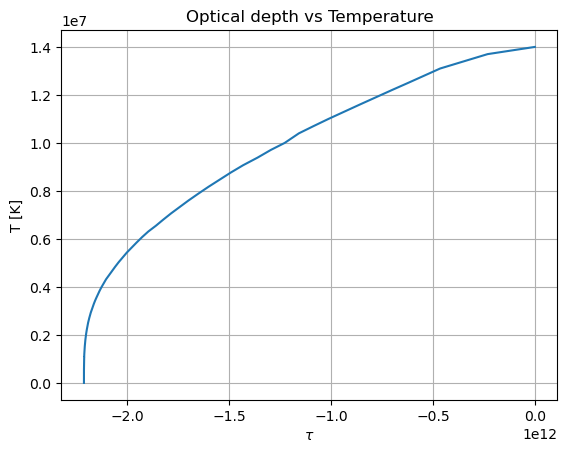

In [180]:
#Tomando la temperatura para hacer el gráfico T vs profundidad óptica

T = data[:,3]

#print(T)

import matplotlib.pyplot as plt

plt.plot(tau_total, T)
#plt.xscale('log')
plt.title('Optical depth vs Temperature')
plt.xlabel(r'$\tau$')
plt.ylabel('T [K]')
plt.grid(True)

# Mostrar el gráfico
plt.show()

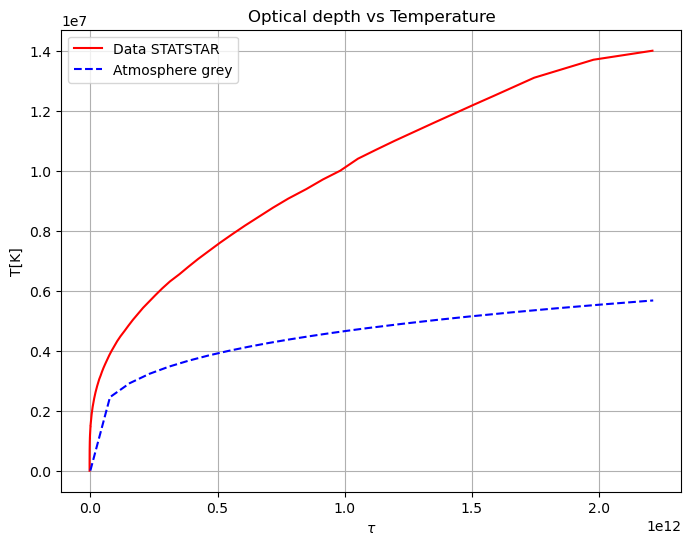

In [187]:
#Modelo atm gris

def T_grey(t):
    return 5000*(-0.75*t+0.5)**0.25 

#t = np.linspace(0, 25, 100)

T_grey=T_grey(tau_total) #Teff = 5000


#Graficando modelo de atm gris y modelo atm real
plt.figure(figsize=(8, 6)) 
plt.plot(tau_total+2.21e12, T, label='Data STATSTAR', linestyle='-', color='r') 
plt.plot(-tau_total, T_grey, label='Atmosphere grey', color='blue', linestyle='--')

plt.title('Optical depth vs Temperature')
plt.xlabel(r'$\tau$')
plt.ylabel('T[K]')
plt.grid(True)

plt.legend()
plt.show()